In [1]:
# this program has the following structure:
# input = 100 pairs of x-y points
# output = 8 pairs of x-y that are the control points of a bezier curve

In [2]:
%matplotlib inline
from geomdl import BSpline
from geomdl import utilities

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import random
import numpy as np
tf.enable_eager_execution()

In [3]:
# those are utilities to generate the training data
n_evalpts = 100
def evalpts(ctrlpts):
    c = BSpline.Curve()
    c.degree = 2
    c.ctrlpts = ctrlpts
    c.delta = 1/(n_evalpts-0.5)
    c.knotvector = utilities.generate_knot_vector(c.degree, len(c.ctrlpts))
    c.render
    return c.evalpts

def mevalpts(ctrlptslist):
    evalptslist=[]
    for i in range(len(ctrlptslist)):
        evalptslist.append(evalpts(ctrlptslist[i]))
    return evalptslist
 
#curve = evalpts([[5.0, 10.0], [15.0, 25.0], [30.0, 30.0], [45.0, 5.0], [55.0, 5.0],
#                 [70.0, 40.0], [60.0, 60.0], [35.0, 60.0]])

In [4]:
#generate X samples of inputs (100 pairs of points) and outputs (8 pairs)
NUM_SAMPLES = 30000
outputs = tf.random_uniform(shape=[NUM_SAMPLES, 8,2], maxval=5)
inputs = np.array(mevalpts(outputs.numpy().tolist())) #shape [n_evalpts,2]
#inputs = tf.Variable(mevalpts(outputs.numpy().tolist()))
print(inputs.shape)
print(outputs.shape)

(30000, 100, 2)
(30000, 8, 2)


In [5]:
def model():
    model = keras.Sequential([
        layers.Flatten(input_shape=(n_evalpts,2)),
        layers.Dense(256, activation=tf.nn.relu),
        layers.Dense(128, activation=tf.nn.relu),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(16)
    ])
    #optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(
                  loss="mean_squared_error",
                  #loss=loss,  #'mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [6]:
def loss(predicted_evalpts, desired_evalpts):
    return tf.reduce_mean(tf.square(predicted_evalpts - desired_evalpts))

In [7]:
model = model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               51456     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
Total params: 95,216
T

In [8]:
loss(outputs,np.reshape(model.predict(np.array(inputs)),(NUM_SAMPLES,8,2)))

<tf.Tensor: id=3194, shape=(), dtype=float32, numpy=9.314837>

In [10]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 50 == 0:
            print ("loss: %.6f, val_loss: %.6f" % (logs["loss"], logs["val_loss"]))
            print('')
        print('.', end='')
    #def on_train_end(self, logs):
    #    print (logs["loss"])

EPOCHS = 5000
history = model.fit(
    inputs,
    np.reshape(outputs,(NUM_SAMPLES,16)),
    epochs=EPOCHS,
    validation_split = 0.05,
    verbose=0,
    callbacks=[PrintDot()]
  )

Instructions for updating:
Use tf.cast instead.
loss: 0.318343, val_loss: 0.013842

..................................................loss: 0.001935, val_loss: 0.000769

..................................................loss: 0.001428, val_loss: 0.000499

..................................................loss: 0.001027, val_loss: 0.000866

..................................................loss: 0.000911, val_loss: 0.000745

..................................................loss: 0.000804, val_loss: 0.000476

..................................................loss: 0.000716, val_loss: 0.003416

..................................................loss: 0.000672, val_loss: 0.000689

..................................................loss: 0.000617, val_loss: 0.000455

..................................................loss: 0.000594, val_loss: 0.000579

..................................................loss: 0.000592, val_loss: 0.000223

..................................................loss: 

..................................................loss: 0.000158, val_loss: 0.000365

..................................................loss: 0.000134, val_loss: 0.000308

..................................................loss: 0.000151, val_loss: 0.000078

..................................................loss: 0.000179, val_loss: 0.000144

..................................................loss: 0.000169, val_loss: 0.000305

..................................................loss: 0.000160, val_loss: 0.000085

..................................................loss: 0.000153, val_loss: 0.000092

..................................................

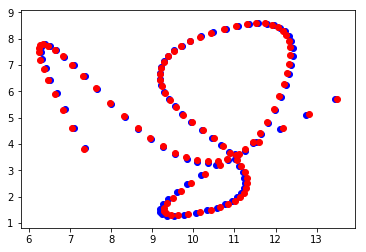

In [14]:
from matplotlib import pyplot as plt
w = tf.random_uniform(shape=[8,2], maxval=15)
i = evalpts(np.asarray(w).tolist())
x, y = np.asarray(i).T
o = evalpts(np.reshape(model.predict(np.reshape(np.asarray(i),(1,n_evalpts,2))),(8,2)).tolist())
a, b = np.asarray(o).T
plt.scatter(x,y, c="b")
plt.scatter(a,b, c="r")

In [ ]:
#model.save_weights("./beziermodelweights")